# Inicializando acesso ao Google Drive

In [1]:
'''
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get -qq install -y software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get -qq update 2>&1 > /dev/null
!apt-get -y -qq install google-drive-ocamlfuse fuse
print('Installed')
'''

"\n# Install a Drive FUSE wrapper.\n# https://github.com/astrada/google-drive-ocamlfuse\n!apt-get -qq install -y software-properties-common python-software-properties module-init-tools\n!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null\n!apt-get -qq update 2>&1 > /dev/null\n!apt-get -y -qq install google-drive-ocamlfuse fuse\nprint('Installed')\n"

In [2]:
'''
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

#print 'Files in Drive:'
!ls drive/"Colab Notebooks"/i2dl/tp1/dl/datasets/"cifar-10-batches-py"/
'''

'\n# Generate auth tokens for Colab\nfrom google.colab import auth\nauth.authenticate_user()\n\n# Generate creds for the Drive FUSE library.\nfrom oauth2client.client import GoogleCredentials\ncreds = GoogleCredentials.get_application_default()\nimport getpass\n!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL\nvcode = getpass.getpass()\n!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}\n\n# Create a directory and mount Google Drive using that directory.\n!mkdir -p drive\n!google-drive-ocamlfuse drive\n\n#print \'Files in Drive:\'\n!ls drive/"Colab Notebooks"/i2dl/tp1/dl/datasets/"cifar-10-batches-py"/\n'

# Atividade 05: Utilizando Descritores de Imagem

*Complete e entregue toda essa atividade (incluindo suas saÃ­das e qualquer cÃ³digo adicional que vocÃª desenvolva) juntamente com a submissÃ£o de seu trabalho prÃ¡tico. Maiores detalhes podem ser vistos na pÃ¡gina da disciplina.*

VocÃª viu que Ã© possÃ­vel se alcanÃ§ar um resultado razoÃ¡vel na tarefa de classificaÃ§Ã£o de imagens por meio do treinamento de um classificador linear utilizando os pixels da imagem como entrada.

Nesta atividade, vocÃª irÃ¡ explorar a possibilidade de melhorar o desempenho de clssificaÃ§Ã£o por meio do treinamento de um classificador nÃ£o sobre os pixels brutos mas sobre descritores (ou caracterÃ­sticas) calculados a partir dos pixels brutos.

Nesta atividade, vocÃª irÃ¡:

- extrair **descritores** (ou **caracterÃ­sticas**) a partir das imagens do dataset
- treinar um **classificador SVM sobre dos descritores** extraÃ­dos e avaliar seu desempenho de classificaÃ§Ã£o
- treinar uma **rede neural sobre dos descritores** extraÃ­dos e avaliar seu desempenho de classificaÃ§Ã£o


In [3]:
import random
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [4]:
#PATH_DIRECTORY = 'drive/Colab Notebooks/i2dl/tp1'
#os.chdir(PATH_DIRECTORY)
from dl.data_utils import load_CIFAR10
from __future__ import print_function

## Leitura de dados
Similar aos exercÃ­cios anteriores, vocÃª vai carregar os dados do CIFAR-10 dataset a partir do disco.

In [5]:
from dl.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Carregga os dados CIFAR-10 brutos
    cifar10_dir = 'dl/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subdivide os dados em conjuntos
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## ExtraÃ§Ã£o de Descritores (ou CaracterÃ­sticas)
Para imagem, vocÃª irÃ¡ calcular um Histograma de Gradientes Orientados (HOG - 
Histogram of Oriented Gradients), bem como um histograma de cores utilizando o canal
de matiz (*hue*) do espaÃ§o de cores HSV. O descritor final de cada imagem serÃ¡ um vetor 
obtido pela concatenaÃ§Ã£o dos vetores correspondendes ao HOG e ao histograma de cor.

De forma simplificada, pode-se dizer que o HOG captura a informaÃ§Ã£o de textura da
imagem ignorando informaÃ§Ãµes sobre cores, enquanto o histograma de cor representa 
a cor da imagem de entrada ignorando a textura. Dessa forma, espera-se que o uso dos dois 
em conjunto produza um resultado melhor que o obtido por qualquer um dos dois separadamente.
VerificaÃ§Ã£o dessa suposiÃ§Ã£o poderia ser uma possÃ­vel tentativa para ser realizada na seÃ§Ã£o de bonus.

Ambas as funÃµes `hog_feature` e `color_histogram_hsv` operam sobre uma Ãºnica imagem
e retornam um vetor de caracterÃ­sticas (descritor) para essa imagem. Assim, a funÃ§Ã£o 
de extraÃ§Ã£o de descritores `extract_features` recebe como entrada um conjunto de imagens
e uma lista de funÃ§Ãµes de extraÃ§Ã£o de descritores. Em seguida, ela executa cada uma das 
funÃ§Ãµes de extraÃ§Ã£o de descritores sobre cada imagem do conjunto, armazenando os resultados
em uma matriz em que cada linha estÃ¡ associada a uma imagens e cada coluna representa a 
concatenaÃ§Ã£o de todos os vetores de caracterÃ­sticas obtidos para essa imagem.

In [6]:
from dl.features import *

num_color_bins = 10 # NÃºmero de slots (bins) do histograma de cor
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessamento: Subtrair o descritor mÃ©dio
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessamento: Dividir pelo desvio padrÃ£o. Isto assegura que cada descritor
# possui aproximadamente a mesma escala.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessamento: acrescenta uma dimensÃ£o de viÃ©s (bias) necessÃ¡ria ao SVM
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Treinamento do Classificador SVM sobre os Descritores
Usando o cÃ³digo desenvolvido anteriormente para um classificador SVM multiclasse, vocÃª deve treinar vÃ¡rios SVMs sobre os descritores extraÃ­dos acima. Isto deve alcanÃ§ar resultados melhores que os obtidos pelo treinamento de SVMs diretamente sobre os pixels brutos.

In [7]:
print(X_train.shape)

(49000, 32, 32, 3)


In [8]:
print(X_train_feats.shape, y_train.shape)

(49000, 155) (49000,)


In [9]:
# Usar o conjunto de validaÃ§Ã£o para ajustar a taxa de apredizado e regularizaÃ§Ã£o

from dl.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Escrever o cÃ³digo que escolhe os melhores hiperparÃ¢metros usando o conjunto  #
# de validaÃ§Ã£o. Deve ser muito similar ao cÃ³digo feito para o SVM.             #
# AlÃ©m disso, deve-se armazenar a melhor acurÃ¡cia de validaÃ§Ã£o em best_val     #
# e o objeto LinearSVM que obteve esse resultado em best_svm.                  #
# VocÃª pode experimentar com diferentes nÃºmero de shots (bins) no histograma   #
# de cor. Se vocÃª proceder corretamente deve ser capaz de obter uma acurÃ¡cia   #
# prÃ³xima de 0.44 no conjunto de validaÃ§Ã£o.                                    #
################################################################################

n_iters = 1000

svm = LinearSVM()
best_train = 0
best_lr = 0
best_reg = 0

for lr in learning_rates:
    for reg in regularization_strengths:
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg,
                      num_iters=n_iters, verbose=False)
        
        #predict
        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)
        
        #validate
        cur_train = np.mean(y_train == y_train_pred)
        cur_valid = np.mean(y_val == y_val_pred)
        
        #save results
        results[(lr, reg)] = (cur_train, cur_valid)
        
        #print
        print('lr: %e reg: %e train: %f valid: %f' % (lr, reg, cur_train, cur_valid))
        
        if cur_valid > best_val:
            best_val = cur_valid
            best_train = cur_train
            best_lr = lr
            best_reg = reg
            best_svm = svm #salva svm para uso posterior

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Exibe os resultados.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr: 1.000000e-09 reg: 5.000000e+04 train: 0.104204 valid: 0.107000
lr: 1.000000e-09 reg: 5.000000e+05 train: 0.104306 valid: 0.107000
lr: 1.000000e-09 reg: 5.000000e+06 train: 0.110000 valid: 0.110000
lr: 1.000000e-08 reg: 5.000000e+04 train: 0.332041 valid: 0.336000
lr: 1.000000e-08 reg: 5.000000e+05 train: 0.416306 valid: 0.423000
lr: 1.000000e-08 reg: 5.000000e+06 train: 0.409939 valid: 0.401000
lr: 1.000000e-07 reg: 5.000000e+04 train: 0.415510 valid: 0.421000
lr: 1.000000e-07 reg: 5.000000e+05 train: 0.411367 valid: 0.421000
lr: 1.000000e-07 reg: 5.000000e+06 train: 0.375429 valid: 0.377000
lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.104204 val accuracy: 0.107000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.104306 val accuracy: 0.107000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.110000 val accuracy: 0.110000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.332041 val accuracy: 0.336000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.416306 val accuracy: 0

In [10]:
# Avaliar o melhor modelo SVM com o conjunto de teste
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.387


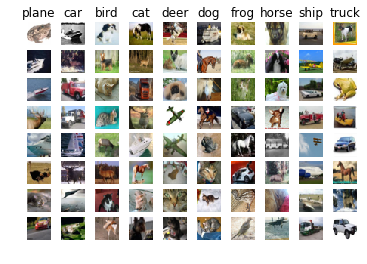

In [11]:
# Um importante mecanismo para se ganhar intuiÃ§Ã£o sobre como um modelo funciona
# Ã© visualizar e analizar os erros que ele comete.
# Nesta visualizaÃ§Ã£o, serÃ£o exibidas exemplos de imagens que foram incorretamente
# classificadas pelo seu modelo.
# A primeira coluna exibe imagens que o seu modelo classificou como aviÃ£o ('plane')
# mas cuja a classificaÃ§Ã£o correta Ã© outra. As outras colunas se comportam de forma
# anÃ¡loga.

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Pergunta 01:
Descreva o que vocÃª observou nos resultados incorrretamente classificados. Eles fazem algum 'sentido'? 

**Sua Resposta:** 

*Sim, Na coluna "plane" existem diversas imagens classificadas incorretamente.*

*Algumas imagens parecem fazer sentido, uma vez que estão em fundos azuis, porém outras como uma ave (bird) em um fundo de terra não aparentam nenhum sentido, correspondendo somente a um erro de classificação. *

## Rede Neural aplicada a Descritores de Imagem
Em uma atividade anterior, vocÃª observou que o treinamento de uma rede neural de duas camadas sobre os pixels brutos das imagens foi capaz de obter um resultado de classificaÃ§Ã£o melhor que o de classificadores lineares para a mesma entrada.

Logo acima, vocÃª acaba de observar que classificadores lineares aplicados a descritores de imagens apresentam resultados superiores aos classificadores lineares aplicados aos pixels brutos. 

Por completudo, agora vocÃª deve tentar treinar uma rede neural sobre os descritores de imagem. 

Essa abordagem deve apresentar um resultado superior a todos as abordagens anteriores: vocÃª deve conseguir facilmente uma acurÃ¡cia de classificaÃ§Ã£o (taxa de acerto) maior que 55% no conjunto de teste. (OBS: minha soluÃ§Ã£o obteve uma acurÃ¡cia em torno de 60%!)

In [14]:
print(X_train_feats.shape[1])

155


In [32]:
from dl.classifiers.neural_net import TwoLayerNet

best_net = None # Armazenar o melhor modelo encontrado nesse variável pois será 
                # usado no teste final (ver final desse notebook)

#################################################################################
# TODO: Ajustar hiperparâmetros usando o conjunto de validação. O melhor modelo #
# obtido ao longo do treinamento deve-se armazenado em best_net.                #
#                                                                               #
# Para auxiliar a depurar sua rede, pode ser interessante se utilizar de        #
# visualizações similares as usadas acima. Essas visualizações irão apresentar  #
# diferenças qualitativas significativas especialmente para redes com ajustes   #
# ruins.                                                                        #
#                                                                               #
# O ajuste fino de hiperparâmetros feito manualmente pode ser divertido, mas    #
# provavelmente você deverá considerar a possibilidade de escrever código que   #
# percorra todas as combinações possíveis de hiperparâmetros de forma a tornar  #
# automático o processo de busca (similar ao que foi feito nas atividades       #
# anteriores).                                                                  #
#################################################################################

results = {}
best_val = -1
learning_rates = [5e-2] #[5e-3] #[1e-3, 5e-4, 1e-4] #[5e-2, 1e-2, 5e-3]
regularization_strengths = [0.005] #, 0.8] #, 0.25] #, 0.4, 0.5]
batch_sizes = [200] #[10, 50, 100, 200]
decay =  [0.95] #[0.8, 0.85, 0.9, 0.95] #[0.9, 0.95]

#num iterações
n_iters = 3000

#net
input_size = X_train_feats.shape[1] # Recupera o tamanho total do vetor de descritores
hidden_size = 2048 #1024
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

#valores
best_train = 0
best_lr = 0
best_reg = 0
best_batch = 0

for lr in learning_rates:
    for reg in regularization_strengths:
        for batch in batch_sizes:
            for dec in decay:
                stats = net.train(X_train_feats, y_train, X_val_feats, y_val, num_iters=n_iters, 
                            batch_size=batch, learning_rate=lr, learning_rate_decay=dec,
                            reg=reg, verbose=False)

                #print
                cur_train = stats['train_acc_history'][-1]
                cur_valid = stats['val_acc_history'][-1]

                print('train: %.4f val: %.4f' % (cur_train, cur_valid))
                print('lr: %e reg: %e batch: %.2f iter: %.0f dec: %.2f' % (lr, reg, batch, n_iters, dec))

                if cur_valid > best_val:
                    best_val = cur_valid
                    best_train = cur_train
                    best_lr = lr
                    best_reg = reg
                    best_batch = batch
                    best_net = net
#################################################################################
#                              FIM DE SEU CÓDIGO                               #
#################################################################################

train: 0.5700 val: 0.5170
lr: 5.000000e-02 reg: 5.000000e-03 batch: 200.00 iter: 3000 dec: 0.95


In [33]:
# Avaliar sua melhor rede neural sobre o conjunto de teste. 
# VocÃª deve ser capaz de obter um resultado acima de 55% de acurÃ¡cia.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.495


# Bonus: Projete seus prÃ³prios descritores!

VocÃª pode observar como simples descritores de imagens podem melhorar o resultado da tarefa de classificaÃ§Ã£o de imagens. AtÃ© agora, vocÃª experimentou com HOG e histograma de cor, porÃ©m outros tipos de descritores poderiam ser capazes de alcanÃ§ar resultados ainda melhores.

Para obter pontos extras, vocÃª deve projetar e implementar um novo tipo de descritor e usÃ¡-lo para classification de imagens do CIFAR-10 dataset.

Explique como seu descritor funciona e por quais razÃµes vocÃª acredita que ele serÃ¡ Ãºtil na tarefa de classificaÃ§Ã£o de imagens. 

VocÃª deve acrescentes cÃ©lulas neste notebook, exemplificando o cÃ¡lculo de seu descritor, a validaÃ§Ã£o cruzada realizada sobre os hiperparÃ¢metros e a anÃ¡lise comparativa de seu desempenho com o *baseline* (representado pelo 'HOG + histograma de cor').

# Bonus: FaÃ§a alguma coisa a mais!
Utilize o material e cÃ³digo apresentado, nessas 05 atividades para fazer algo interessante. 

VocÃª sugere alguma questÃ£o a mais que poderia ter sido feita? 

As atividades propostas despertaram em vocÃª alguma ideia interessante enquanto trabalhava nelas?

Esta Ã© a sua chance de se mostrar (e colaborar, Ã© claro)!

In [8]:
from dl.classifiers.three_layer_net import ThreeLayerNet

best_net = None # Armazenar o melhor modelo encontrado nesse variável pois será 
                # usado no teste final (ver final desse notebook)

results = {}
best_val = -1
learning_rates = [5e-2]
regularization_strengths = [0.001]
batch_sizes = [200]
decay = [0.95]

#num iterações
n_iters = 1500

#net
input_size = X_train_feats.shape[1] # Recupera o tamanho total do vetor de descritores
hidden_size1 = 1024 #1024
hidden_size2 = 128 #1024
num_classes = 10
net = ThreeLayerNet(input_size, hidden_size1, hidden_size2, num_classes, 1e-1)

#valores
best_train = 0
best_lr = 0
best_reg = 0
best_batch = 0

for lr in learning_rates:
    for reg in regularization_strengths:
        for batch in batch_sizes:
            for dec in decay:
                stats = net.train(X_train_feats, y_train, X_val_feats, y_val, num_iters=n_iters, 
                            batch_size=batch, learning_rate=lr, learning_rate_decay=dec,
                            reg=reg, verbose=False)

                #print
                cur_train = stats['train_acc_history'][-1]
                cur_valid = stats['val_acc_history'][-1]

                print('train: %.4f val: %.4f' % (cur_train, cur_valid))
                print('lr: %e reg: %e batch: %.2f iter: %.0f dec: %.2f' % (lr, reg, batch, n_iters, dec))

                if cur_valid > best_val:
                    best_val = cur_valid
                    best_train = cur_train
                    best_lr = lr
                    best_reg = reg
                    best_batch = batch
                    best_net = net
#################################################################################
#                              FIM DE SEU CÓDIGO                               #
#################################################################################

train: 0.5950 val: 0.5310
lr: 5.000000e-02 reg: 1.000000e-03 batch: 200.00 iter: 1500 dec: 0.95


In [9]:
# Avaliar sua melhor rede neural sobre o conjunto de teste. 
# VocÃª deve ser capaz de obter um resultado acima de 55% de acurÃ¡cia.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.54
